# Generative Models

## GANs & VAE

### HW4

**Full Name: Amir Mohammad Ezzati**

**SID: 402212269**

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [ ]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [ ]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [ ]:
num_threads = 4
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mean = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
        ##########################################################


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        h = self.linear(x)
        h = F.relu(h)
        z_mean = self.linear_mean(h)
        logvar = self.linear_logvar(h)
        z_log_var = torch.exp(0.5 * logvar)
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        ##############################

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x = F.sigmoid(h)
        ########################################

        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        z_mean, z_log_var = self.encoder(x)

        # reparameterizing
        eps = torch.randn_like(z_log_var).to(DEVICE)
        z = z_mean + eps * z_log_var

        image = self.decoder(z)
        ##########################################################

        return image, z_mean, z_log_var

In [ ]:
def reconstruct_images(vae, images):
    images = images.view(-1, 784)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images.view(-1, 1, 28, 28)

def plot_images(original, reconstructed, n=4):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    """Elbo loss function."""
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kld

def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim)
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        print(f'Epoch {epoch+1}: ')
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                x = data[0]
                x = x.view(-1, input_dim)
                x = x.to(DEVICE)

                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)

                train_loss += loss.item()

                loss.backward()
                optimizer.step()
                ###############################################

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_images = reconstruct_images(model, sample_images)
        plot_images(sample_images, recon_images)

    return model

Epoch 1: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 252.7596


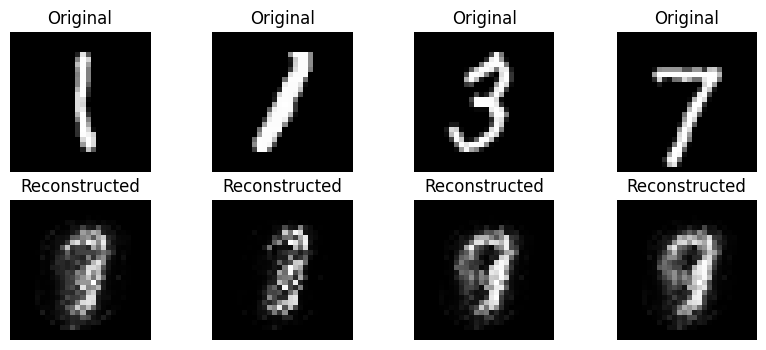

Epoch 2: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 205.7842


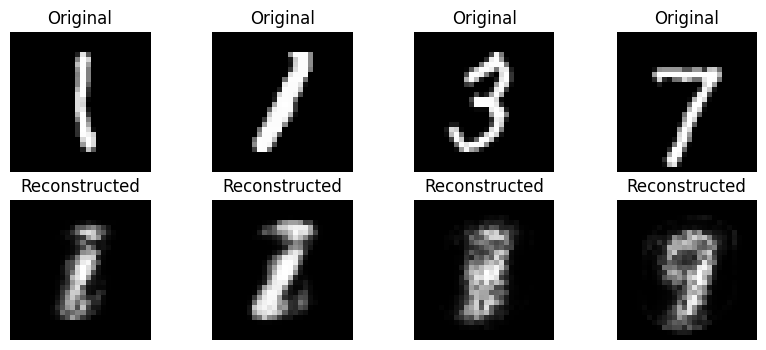

Epoch 3: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 188.5915


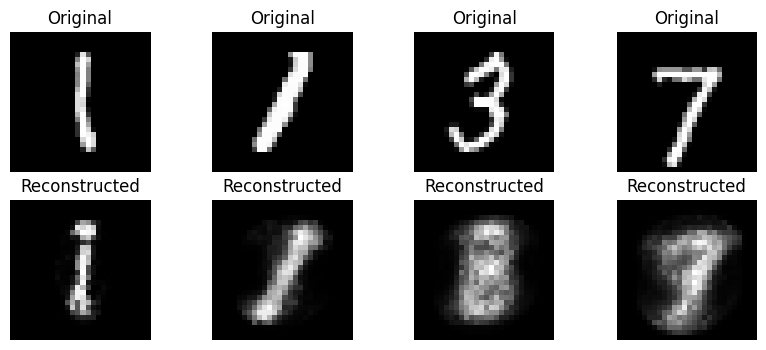

Epoch 4: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 186.9001


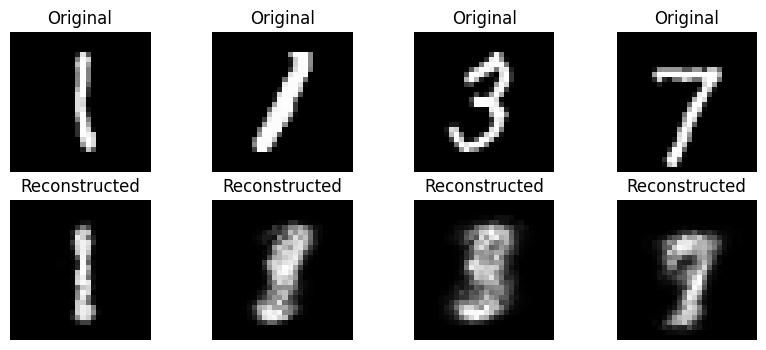

Epoch 5: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 178.1327


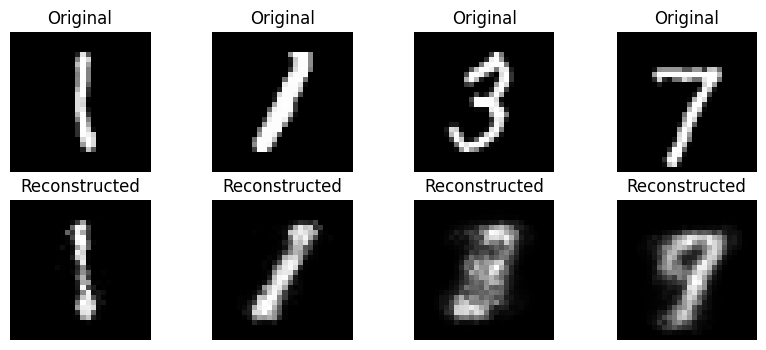

Epoch 6: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 176.6727


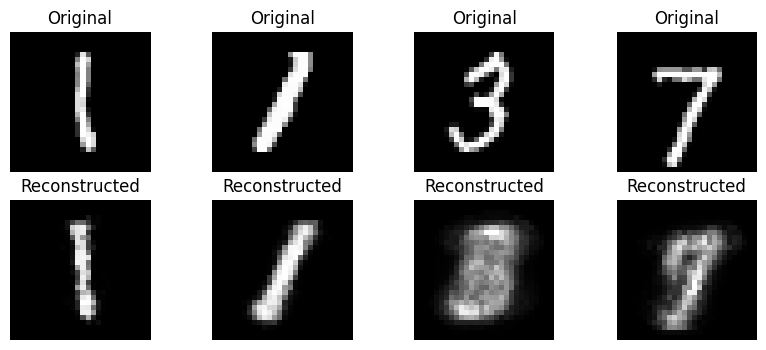

Epoch 7: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 180.6938


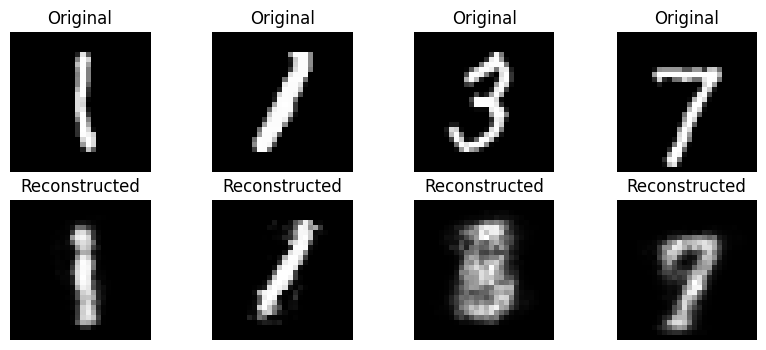

Epoch 8: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 180.5083


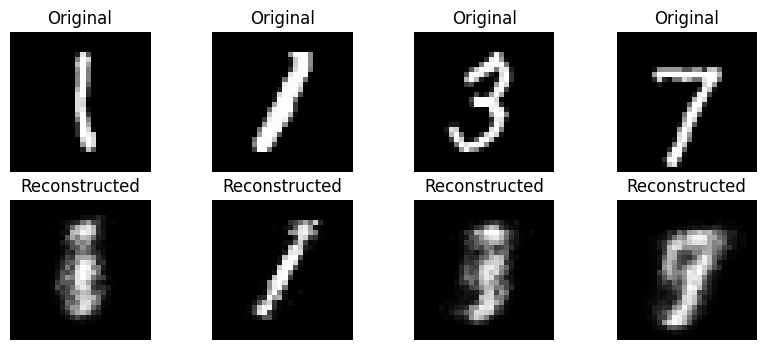

Epoch 9: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 178.2647


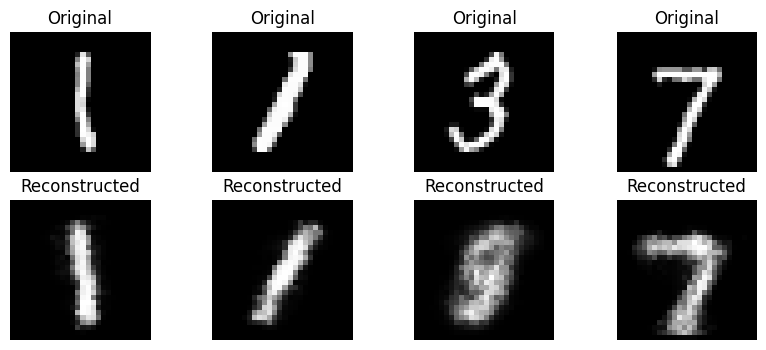

Epoch 10: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 177.6216


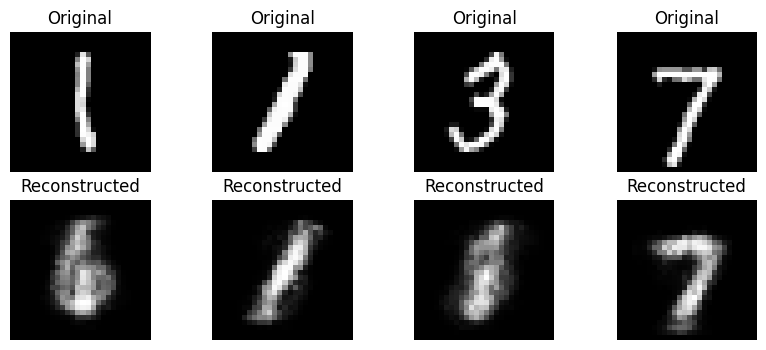

Epoch 11: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 178.8868


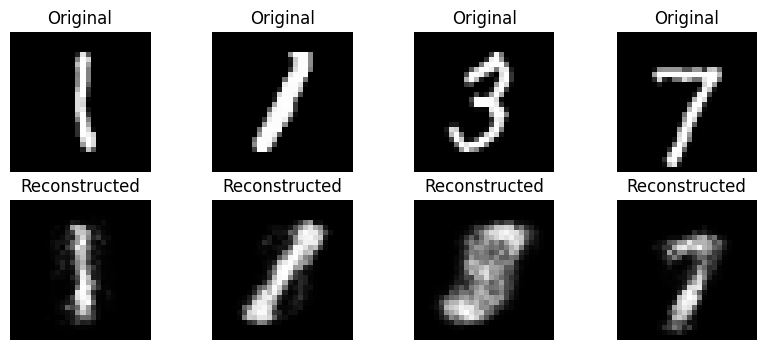

Epoch 12: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 180.9687


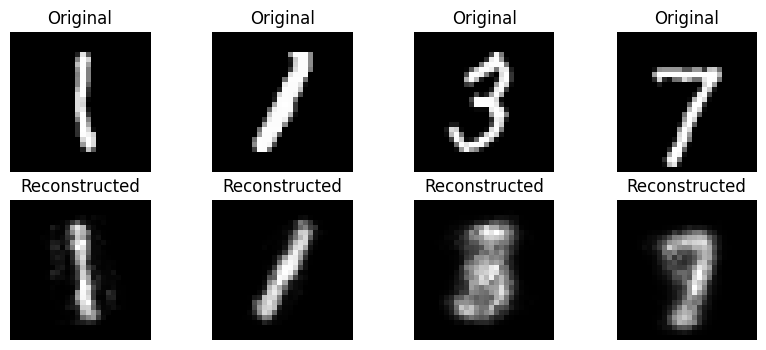

Epoch 13: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 179.3285


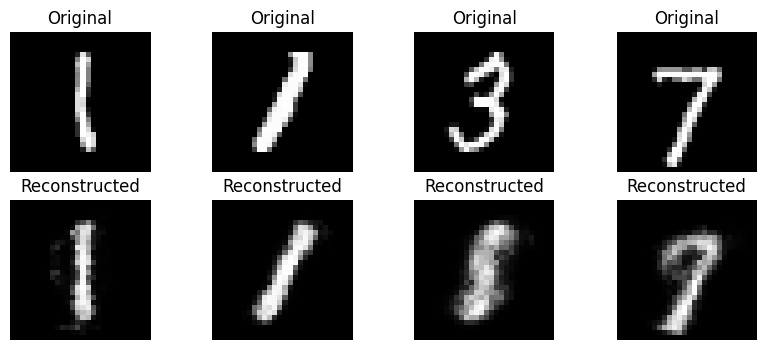

Epoch 14: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 177.8268


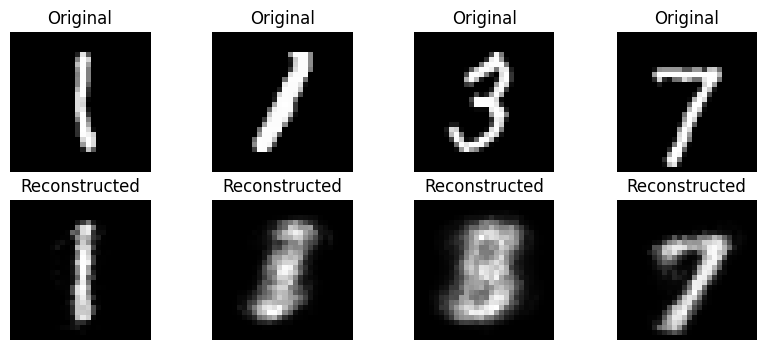

Epoch 15: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 177.8335


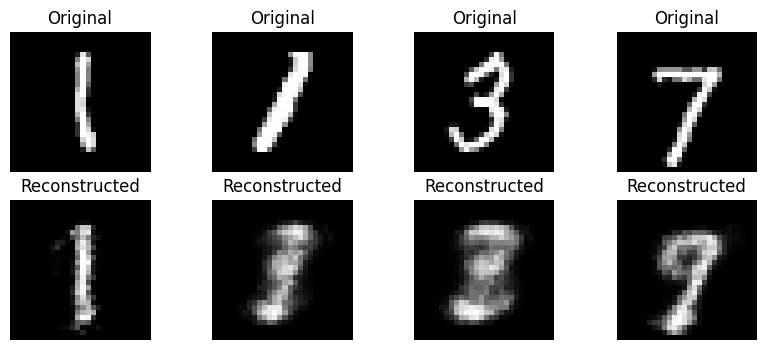

Epoch 16: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 178.7384


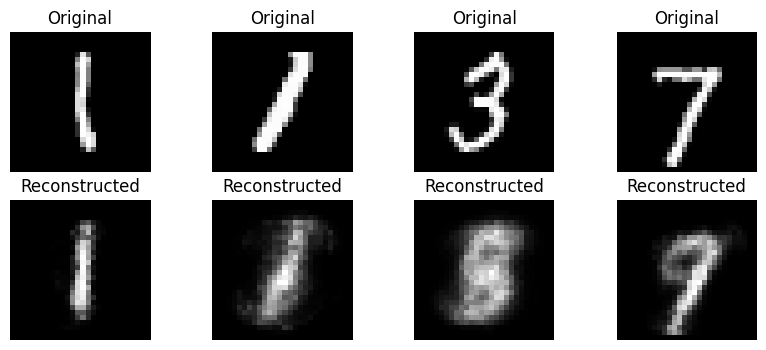

Epoch 17: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 183.6615


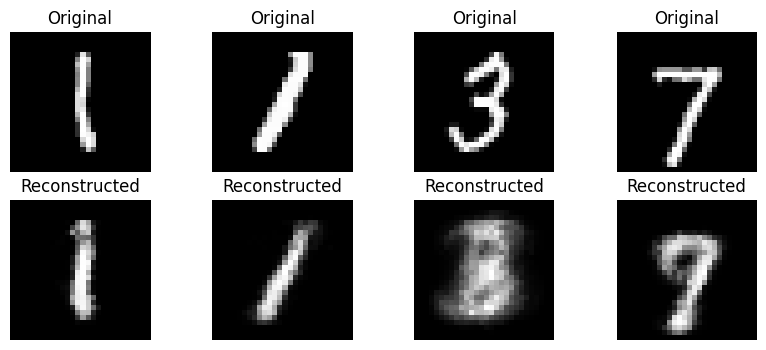

Epoch 18: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 183.6393


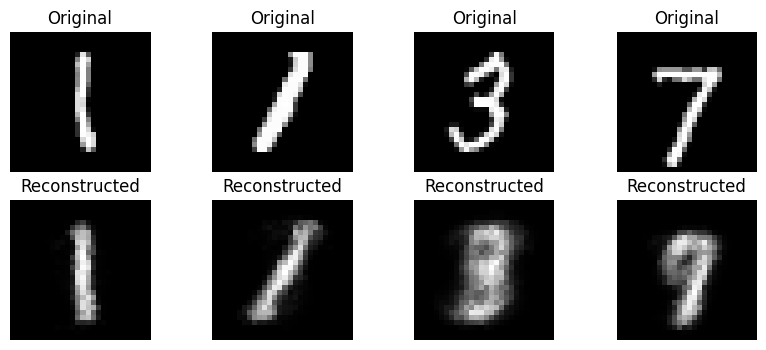

Epoch 19: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 183.6548


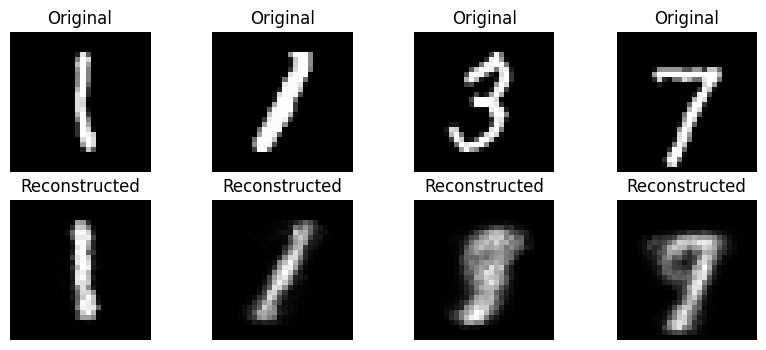

Epoch 20: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 183.7890


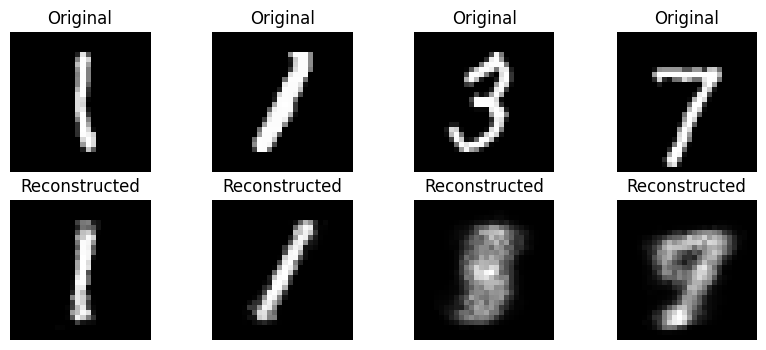

Epoch 21: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 184.6514


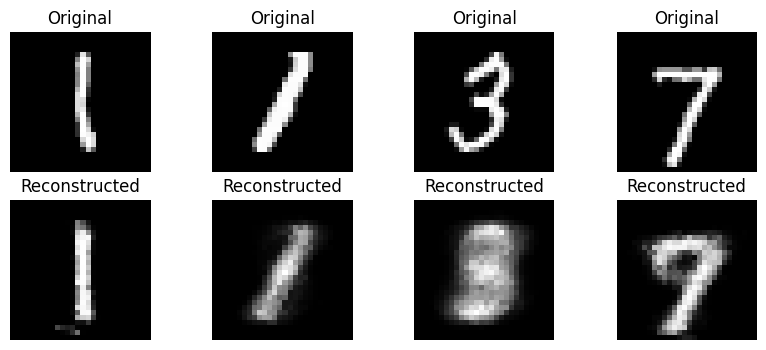

Epoch 22: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 185.6233


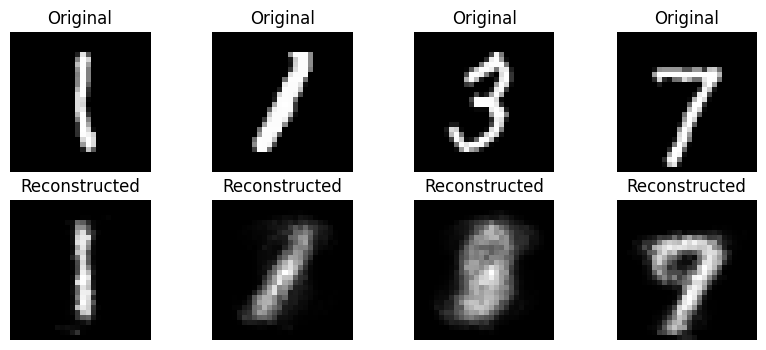

Epoch 23: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 185.6887


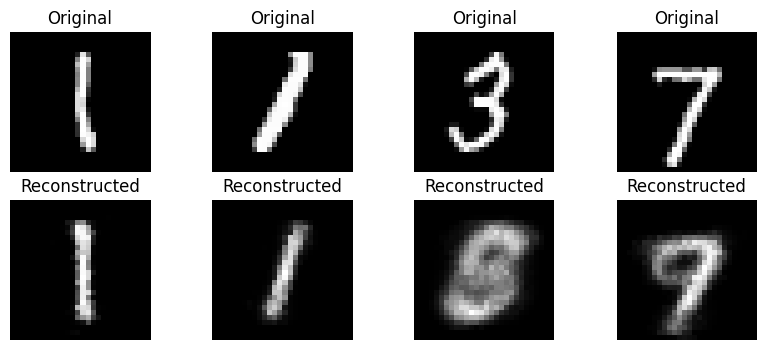

Epoch 24: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 186.4756


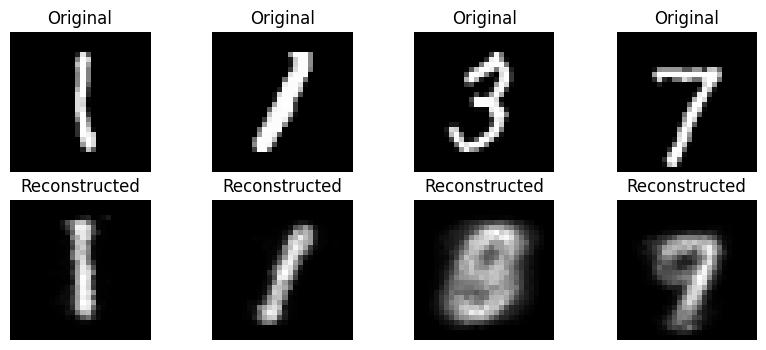

Epoch 25: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 185.3368


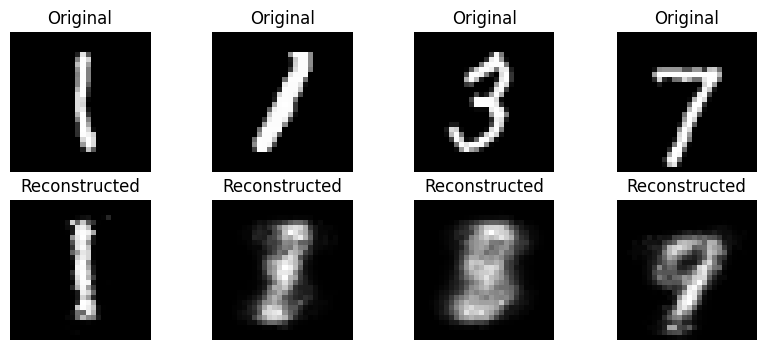

Epoch 26: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 187.2392


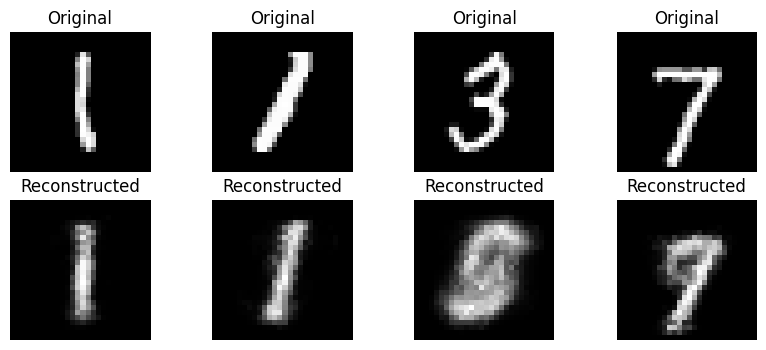

Epoch 27: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 185.5127


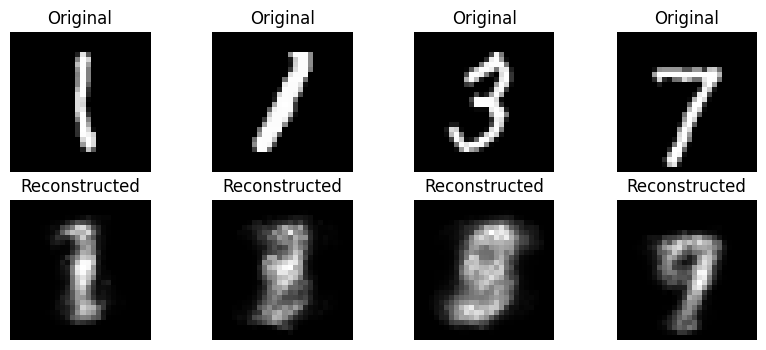

Epoch 28: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 187.1502


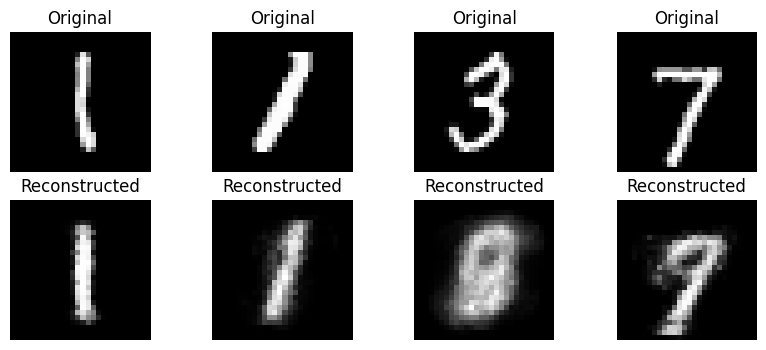

Epoch 29: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 188.8751


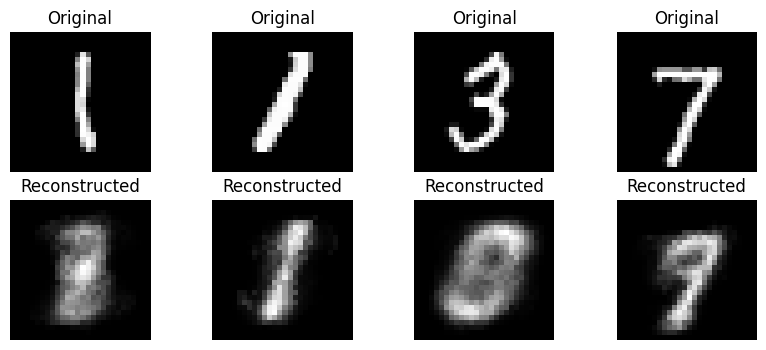

Epoch 30: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 189.0124


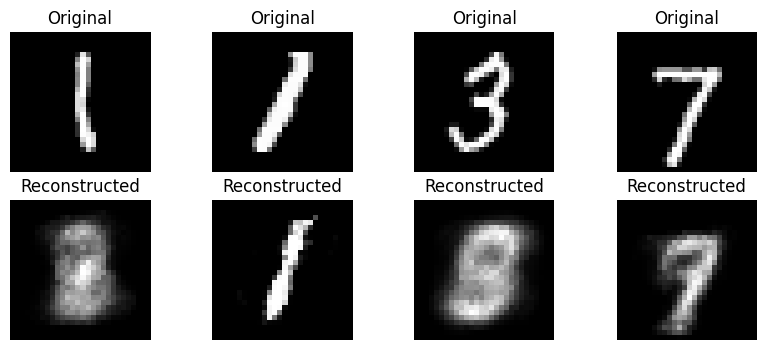

Epoch 31: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 187.8307


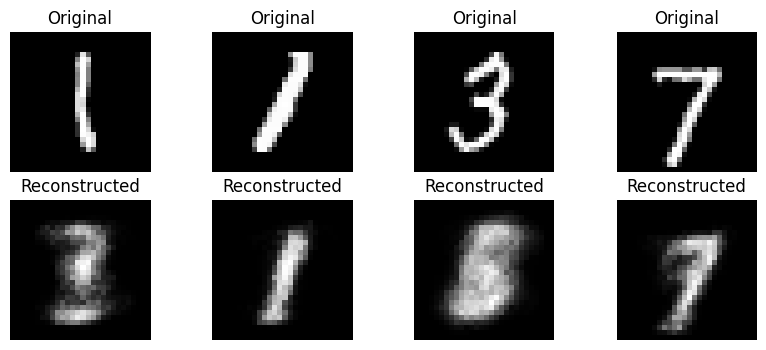

Epoch 32: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 187.5967


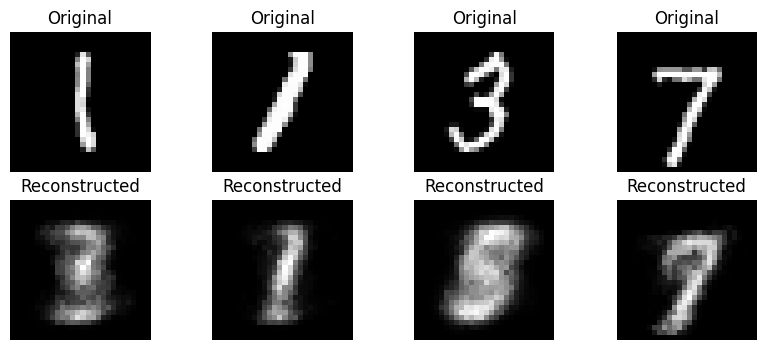

Epoch 33: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 187.0428


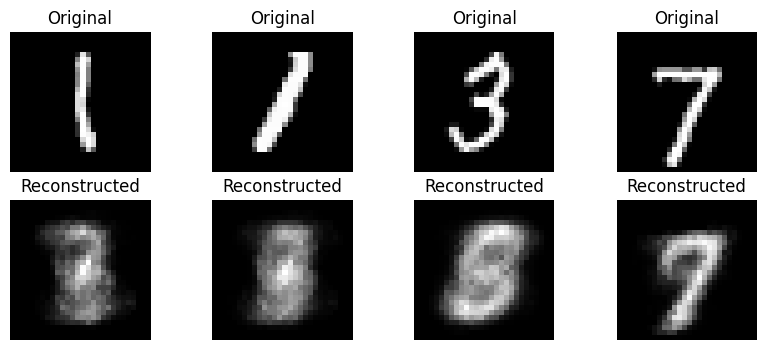

Epoch 34: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 188.8505


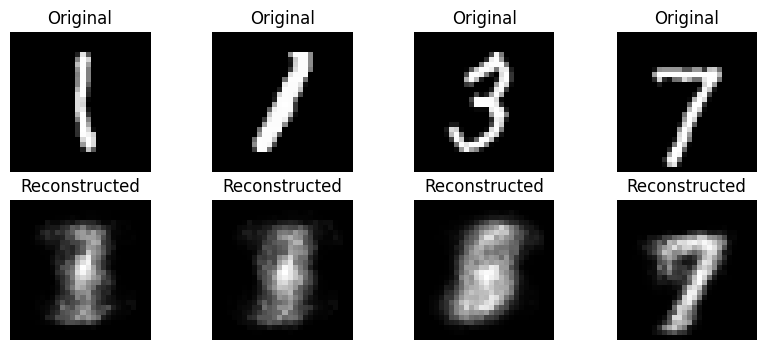

Epoch 35: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 193.2019


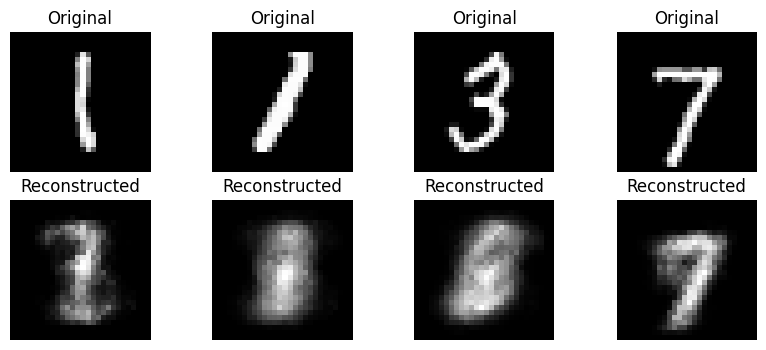

Epoch 36: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 194.4334


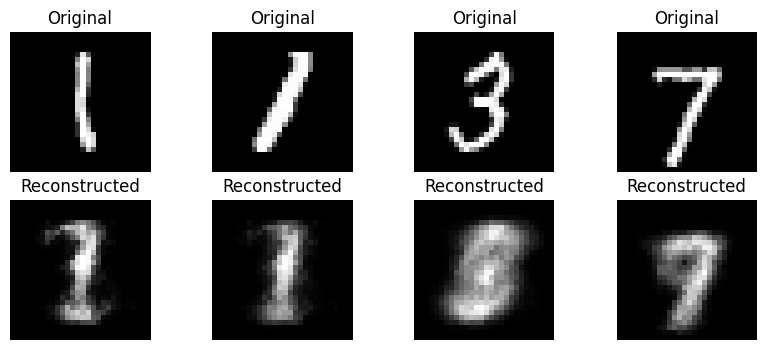

Epoch 37: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 196.4492


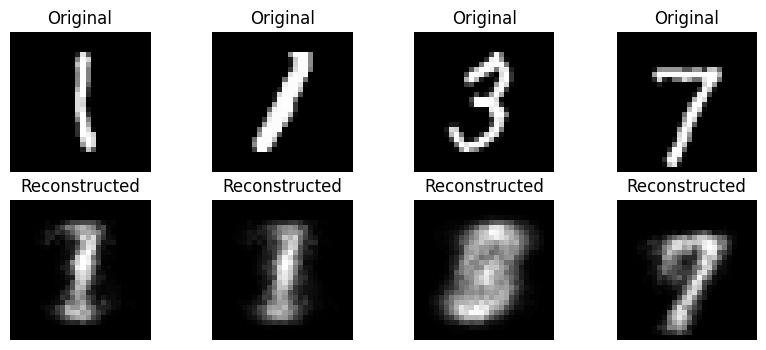

Epoch 38: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 197.7821


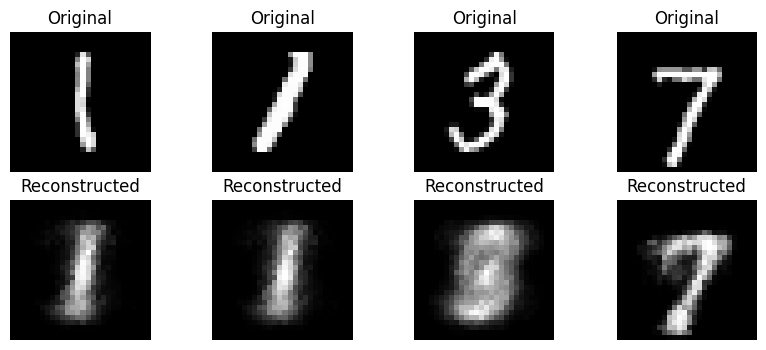

Epoch 39: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 197.0819


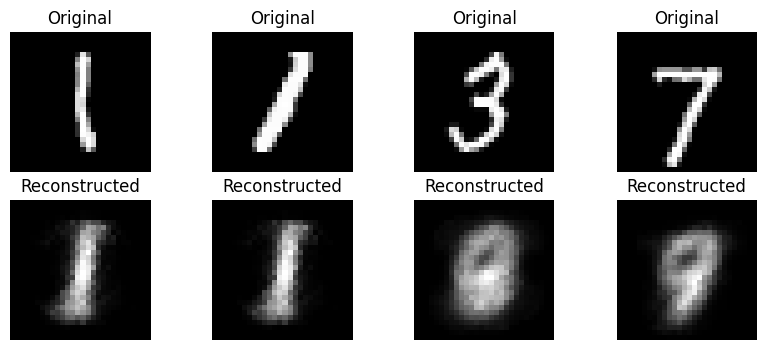

Epoch 40: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.3033


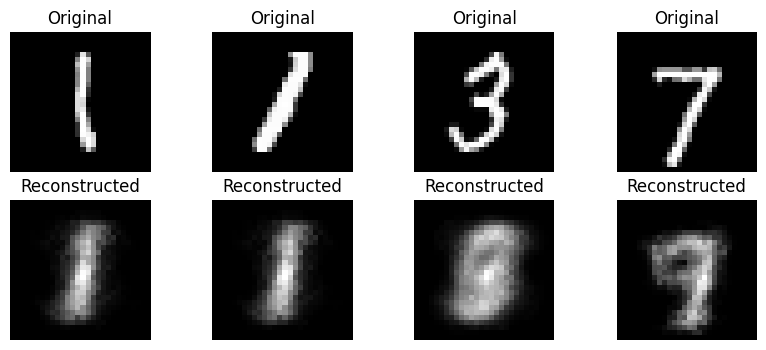

Epoch 41: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 202.6839


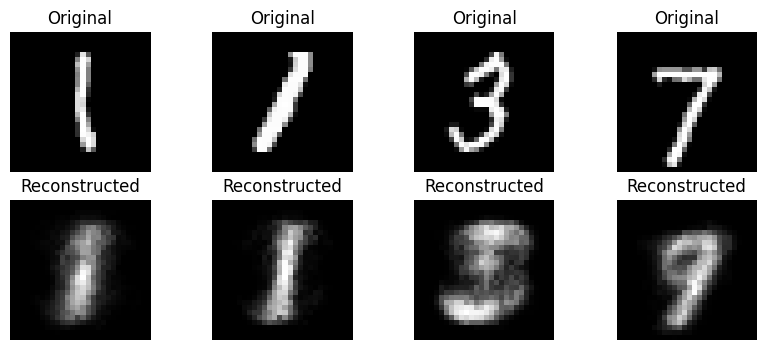

Epoch 42: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.9071


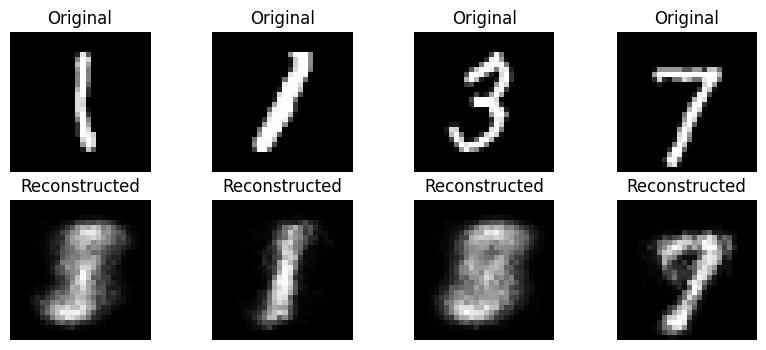

Epoch 43: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.0844


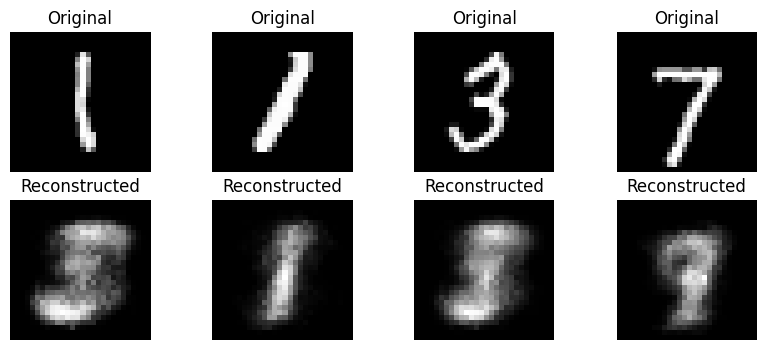

Epoch 44: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.0030


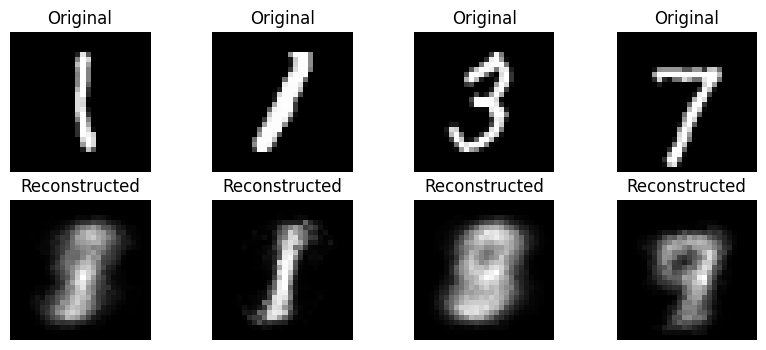

Epoch 45: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.2300


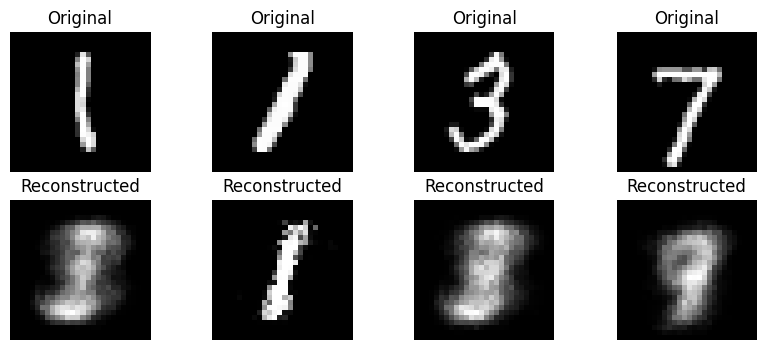

Epoch 46: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.4471


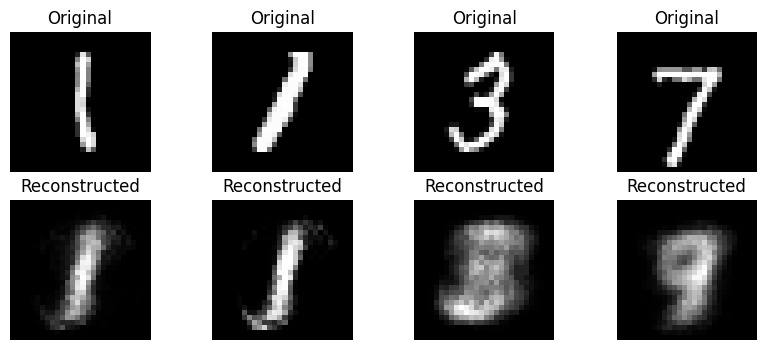

Epoch 47: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.5890


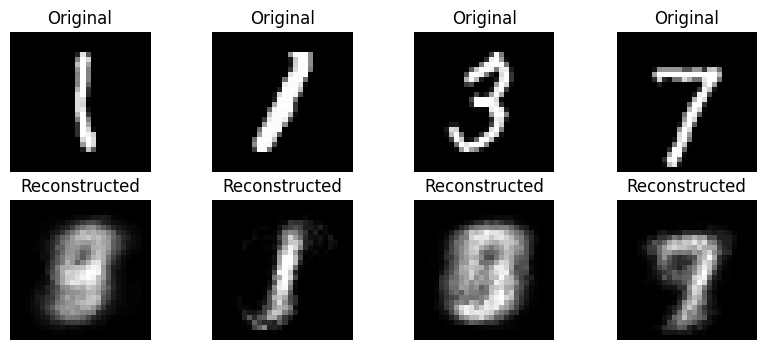

Epoch 48: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.4837


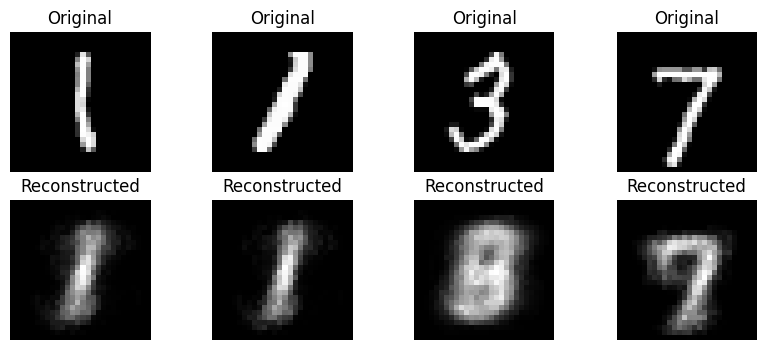

Epoch 49: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.8865


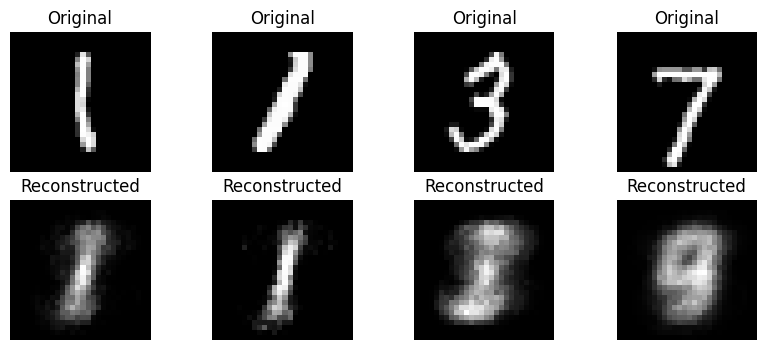

Epoch 50: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.4374


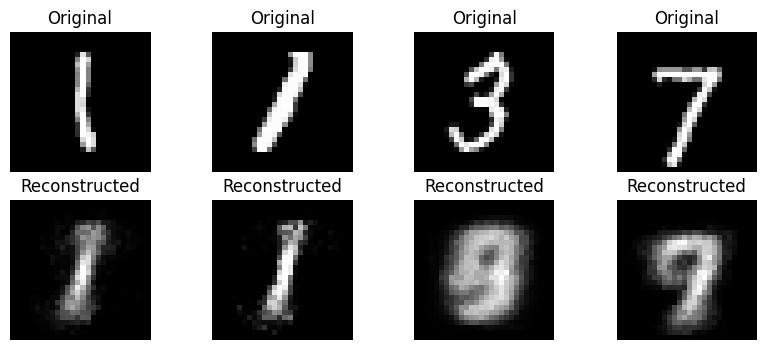

Epoch 51: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.3942


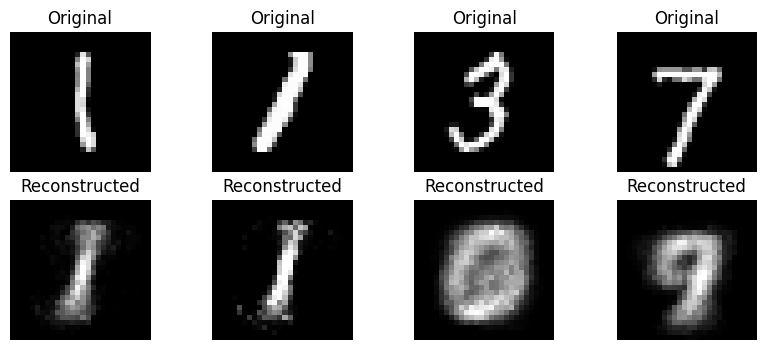

Epoch 52: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.1349


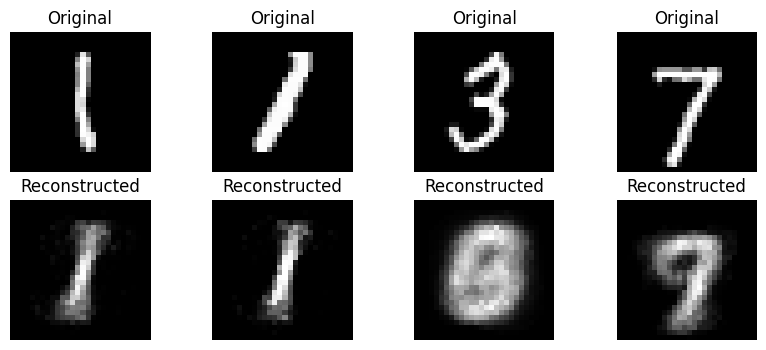

Epoch 53: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.6663


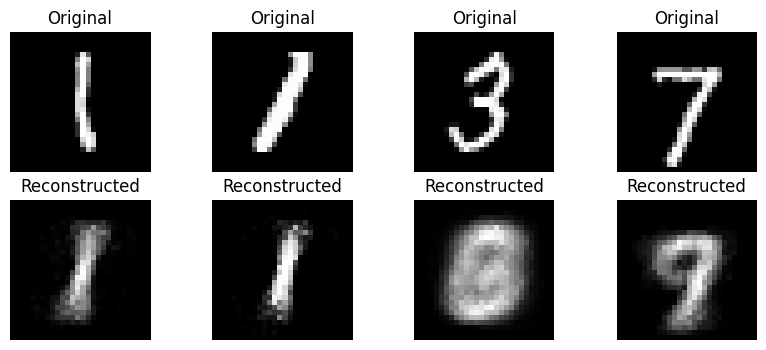

Epoch 54: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.7889


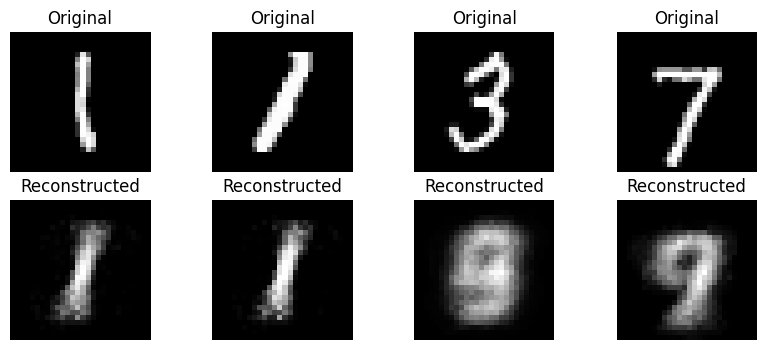

Epoch 55: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.0398


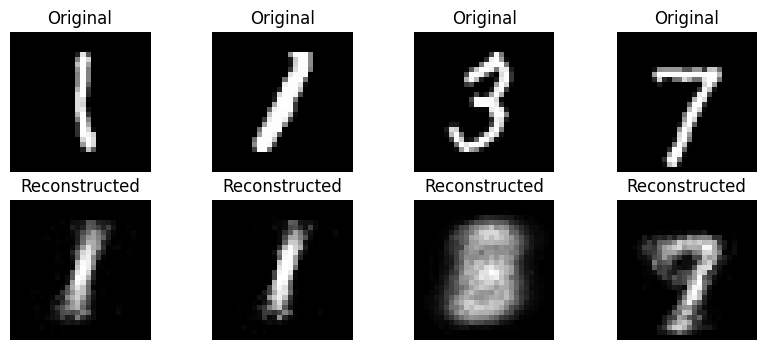

Epoch 56: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.4226


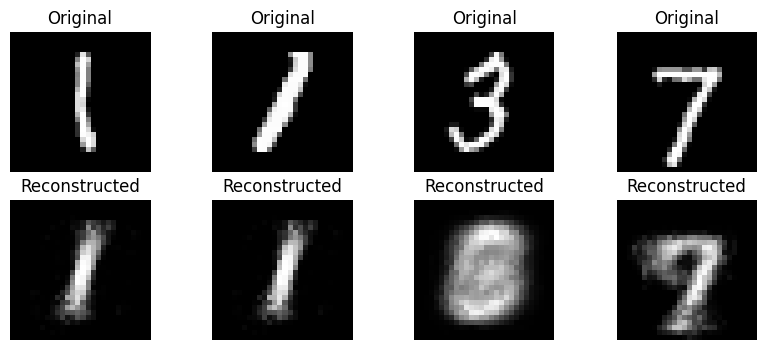

Epoch 57: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.4505


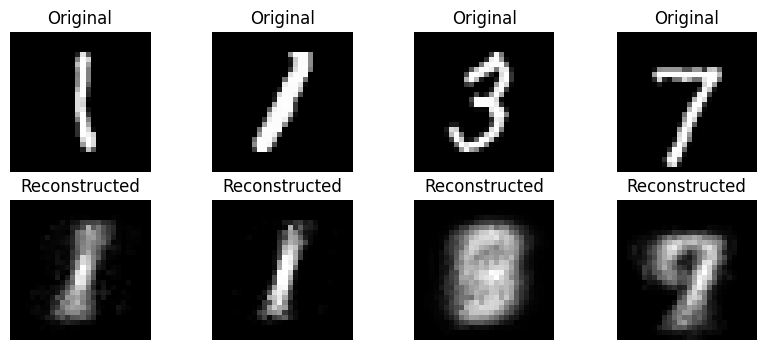

Epoch 58: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.6435


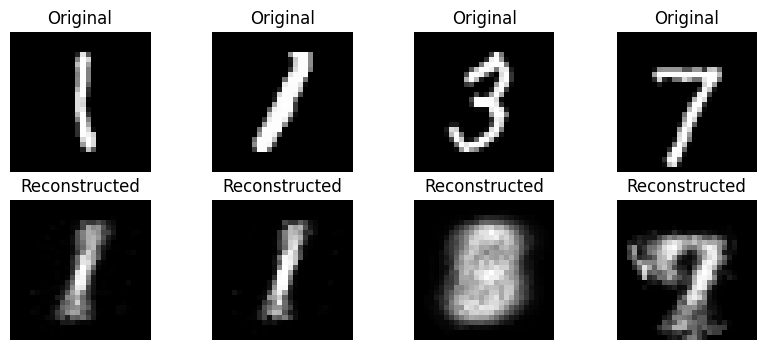

Epoch 59: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.7351


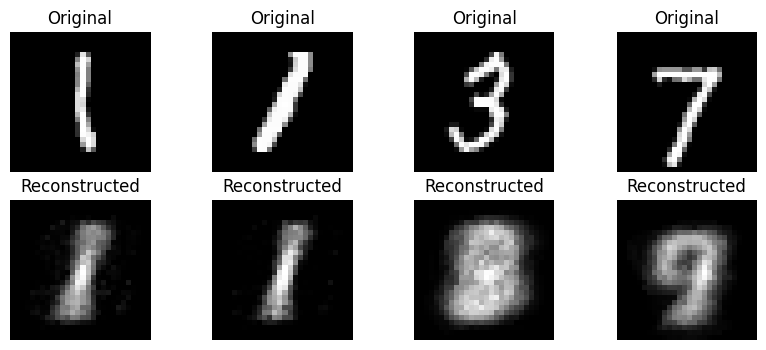

Epoch 60: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.3302


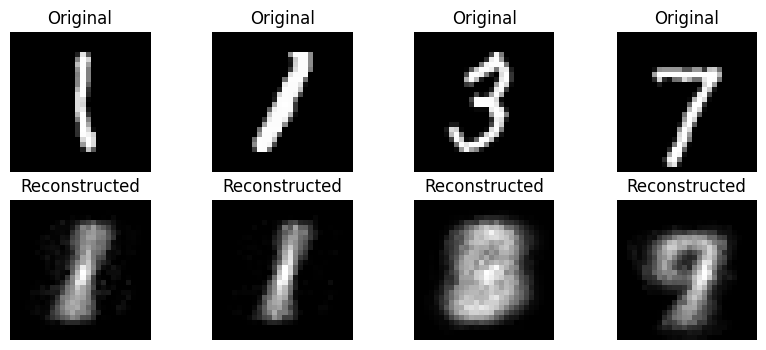

Epoch 61: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.4414


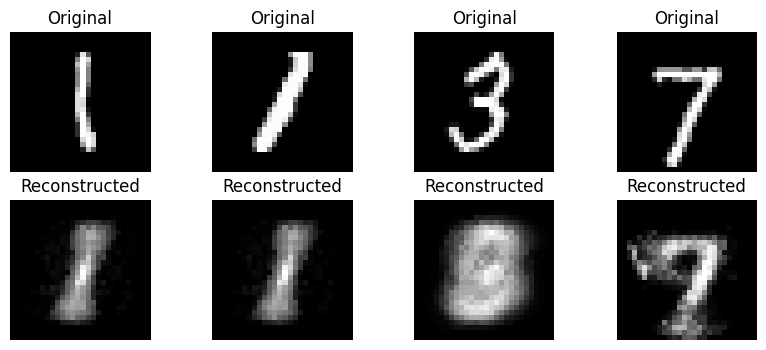

Epoch 62: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.0429


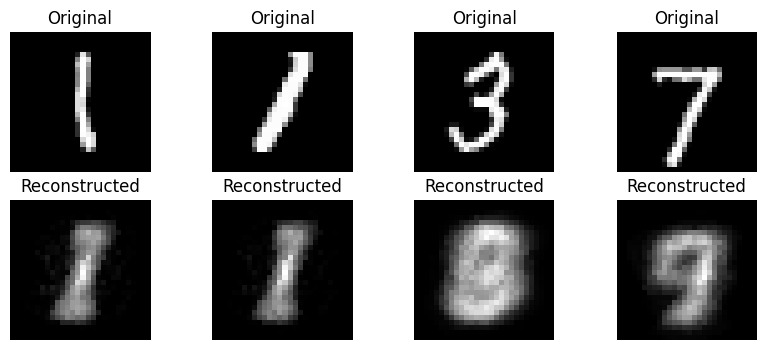

Epoch 63: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.8564


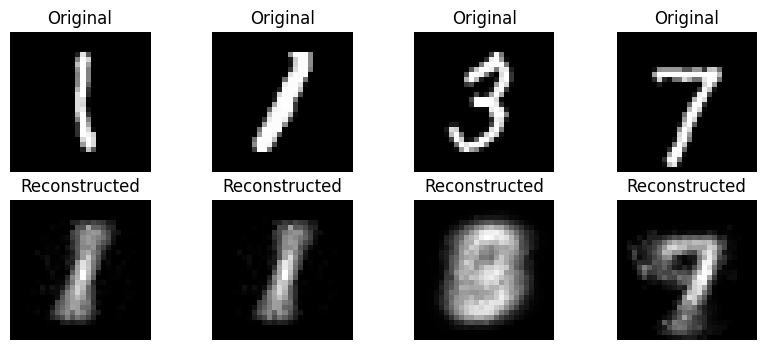

Epoch 64: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.0544


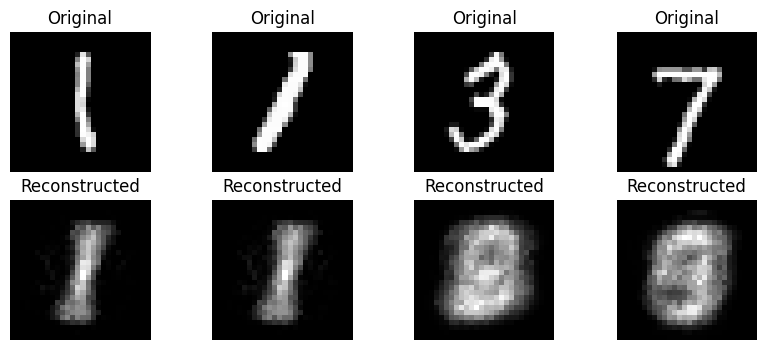

Epoch 65: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.6392


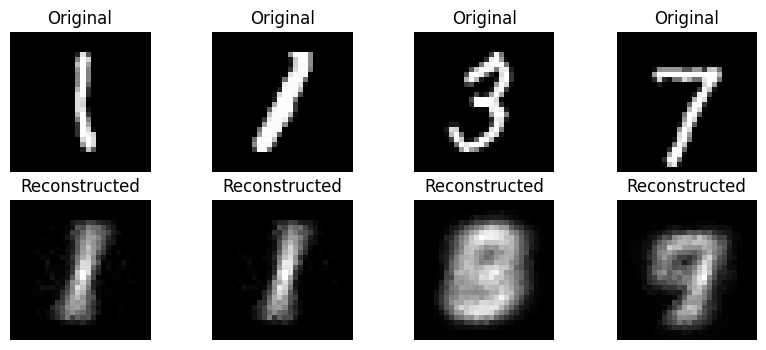

Epoch 66: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.3173


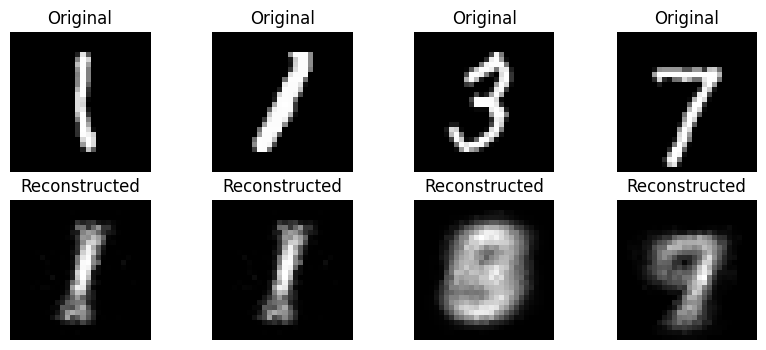

Epoch 67: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.1844


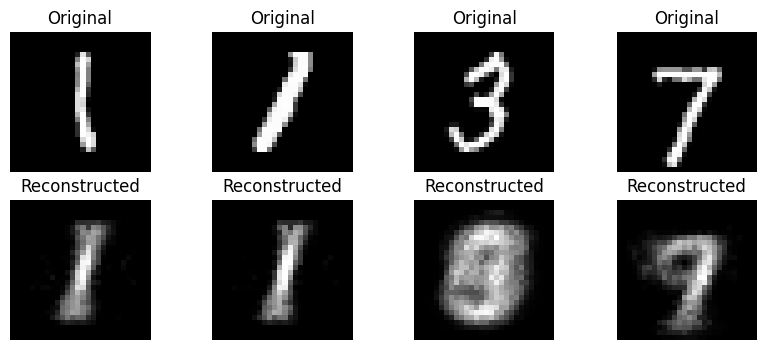

Epoch 68: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.8759


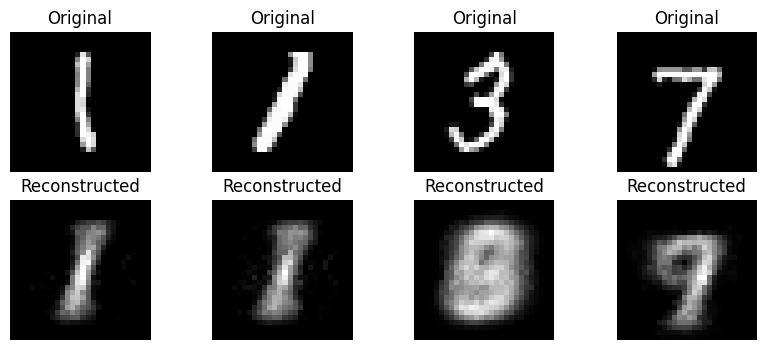

Epoch 69: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.5115


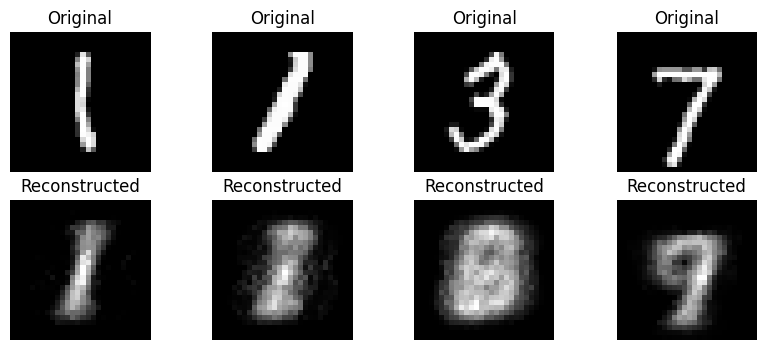

Epoch 70: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.7535


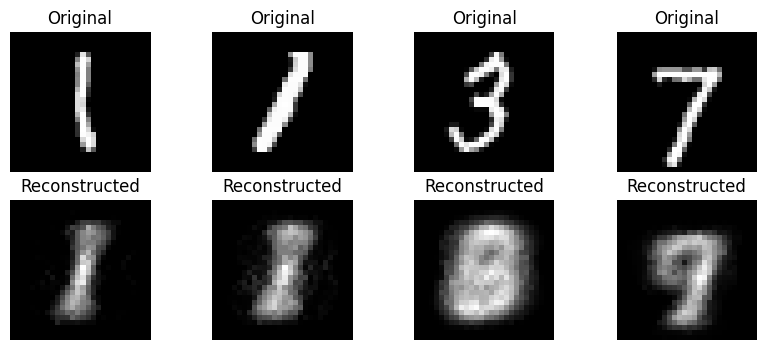

Epoch 71: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.3466


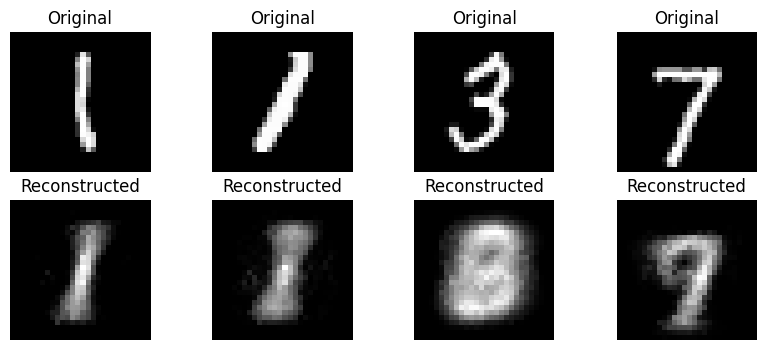

Epoch 72: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.7742


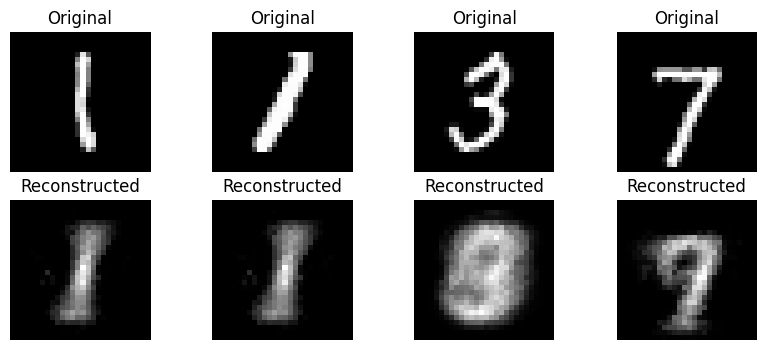

Epoch 73: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.5000


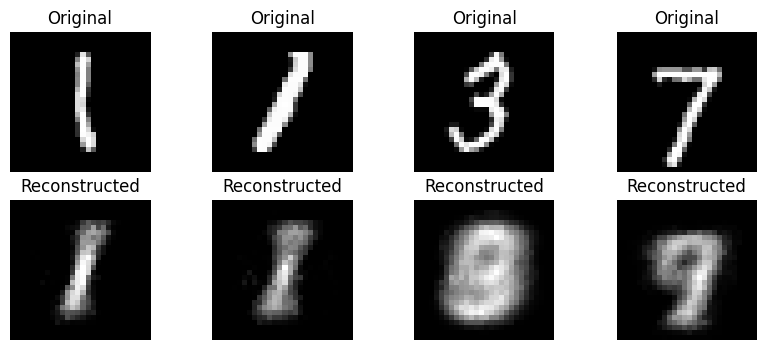

Epoch 74: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.1425


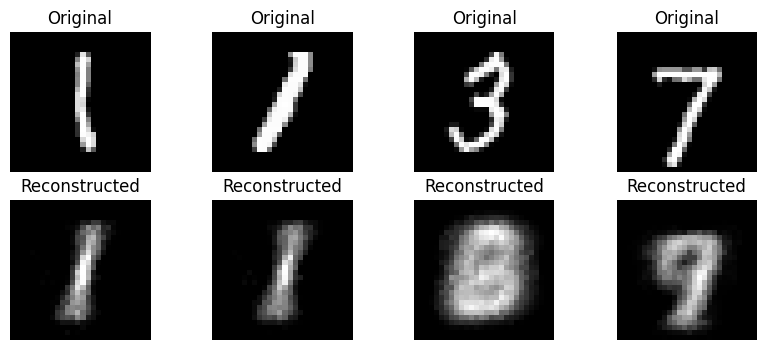

Epoch 75: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.1166


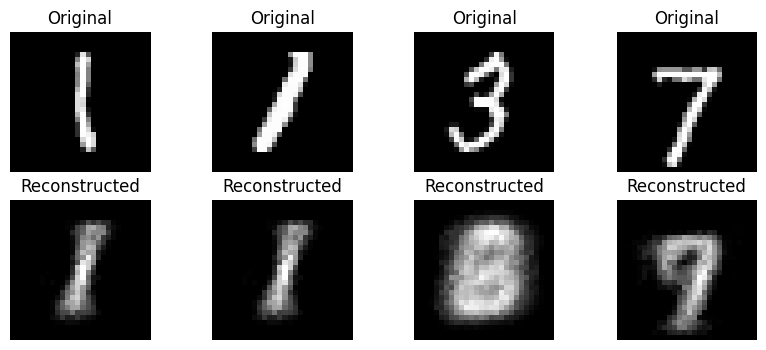

Epoch 76: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.5096


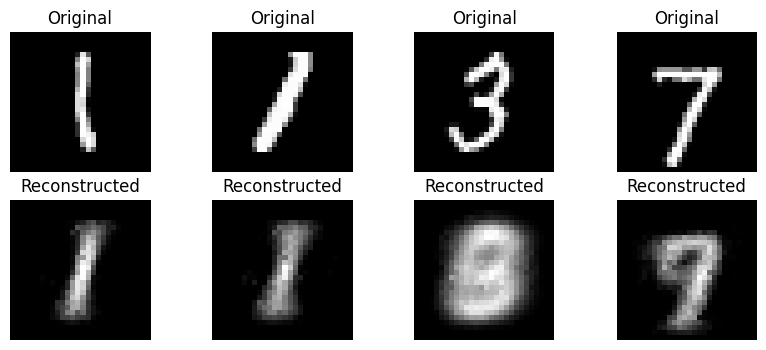

Epoch 77: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.5784


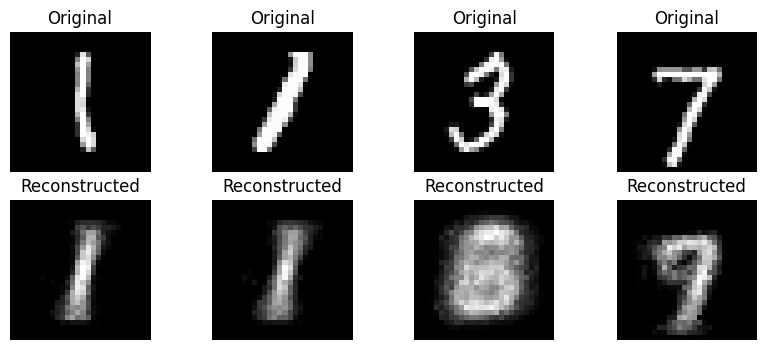

Epoch 78: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.6213


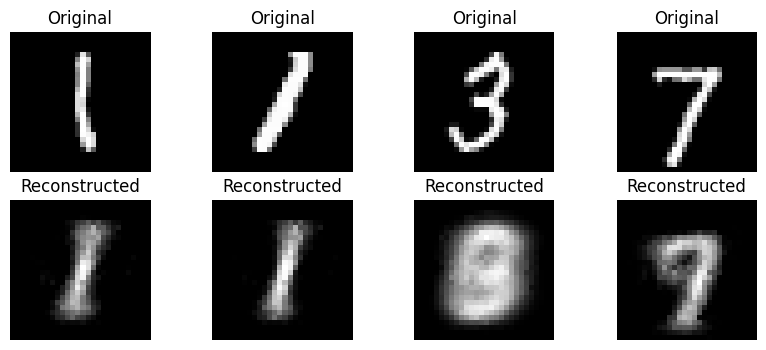

Epoch 79: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.4145


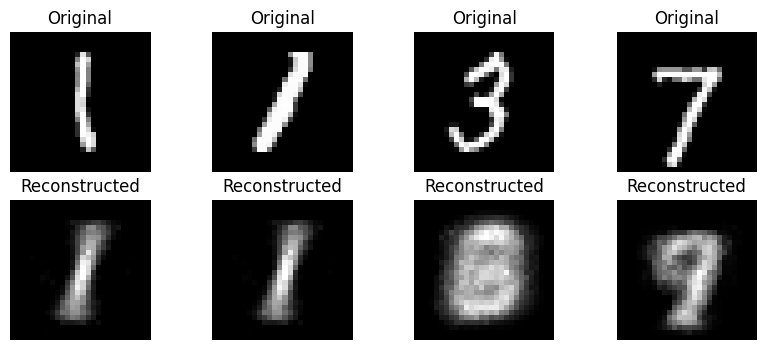

Epoch 80: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 197.1373


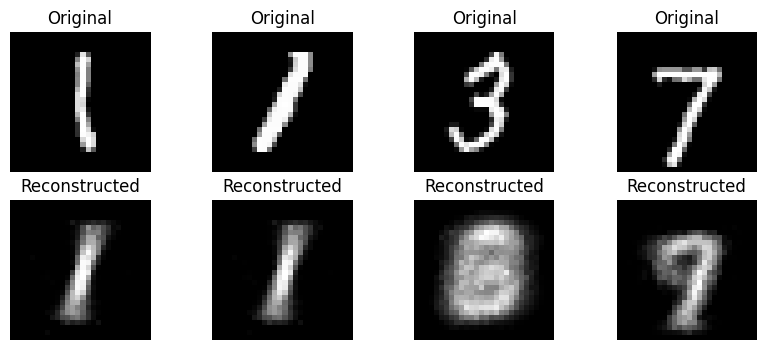

Epoch 81: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 197.6324


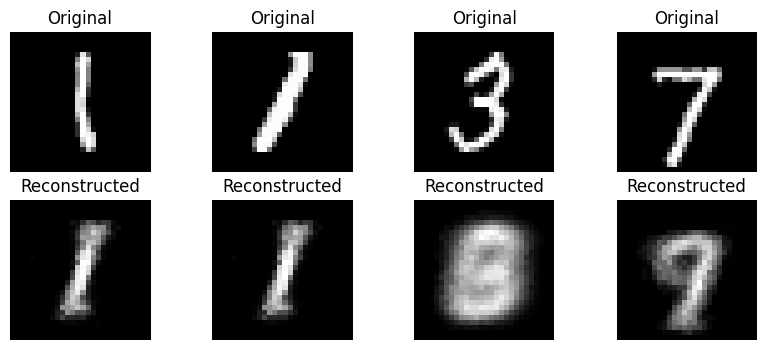

Epoch 82: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.1924


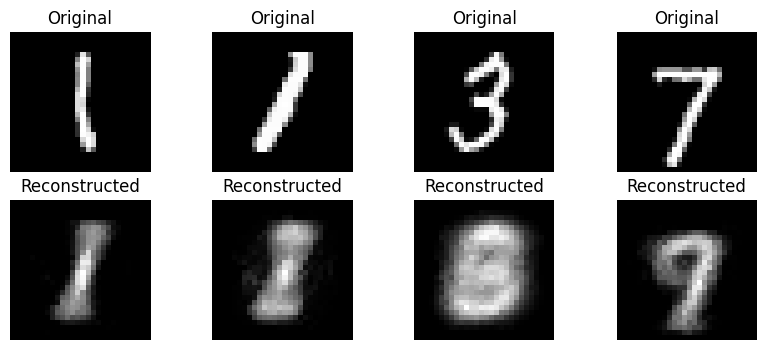

Epoch 83: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.1719


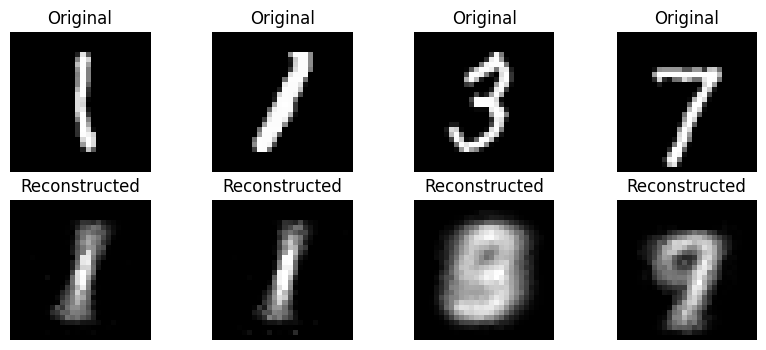

Epoch 84: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.1321


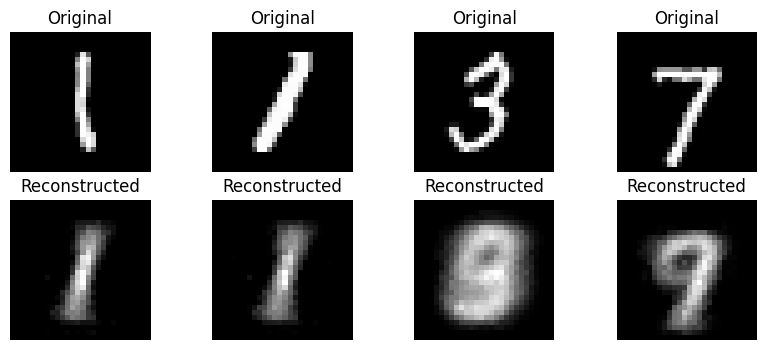

Epoch 85: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.8650


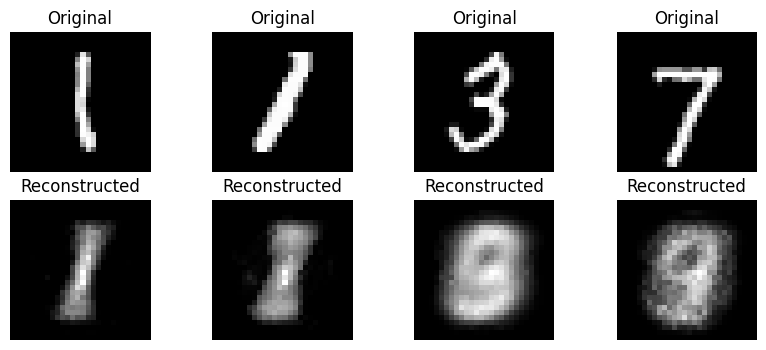

Epoch 86: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.8102


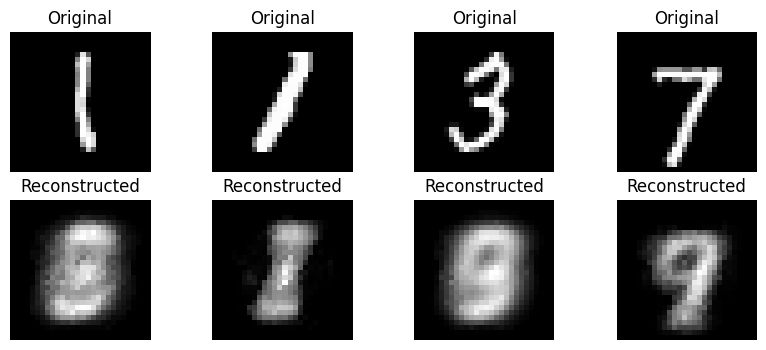

Epoch 87: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.5799


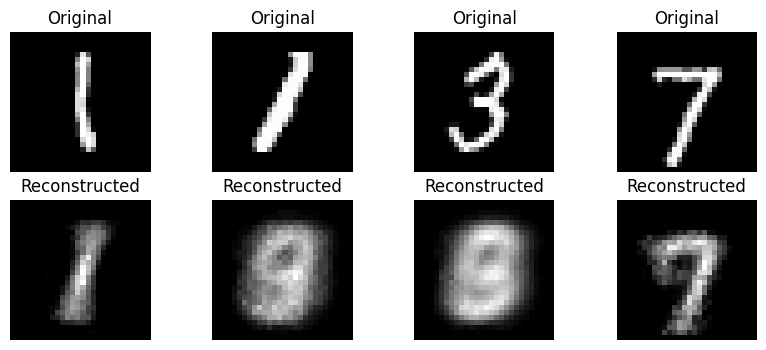

Epoch 88: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.4303


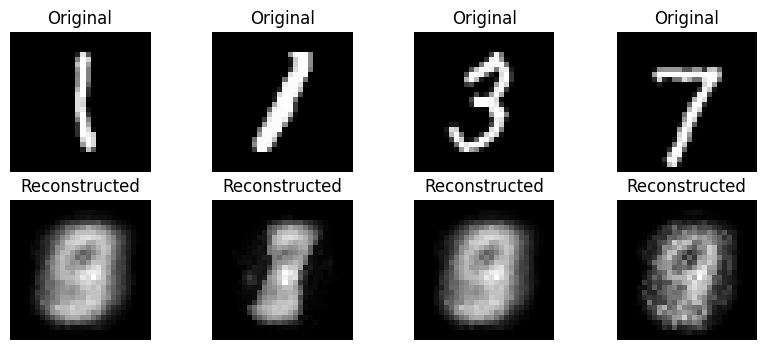

Epoch 89: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.8816


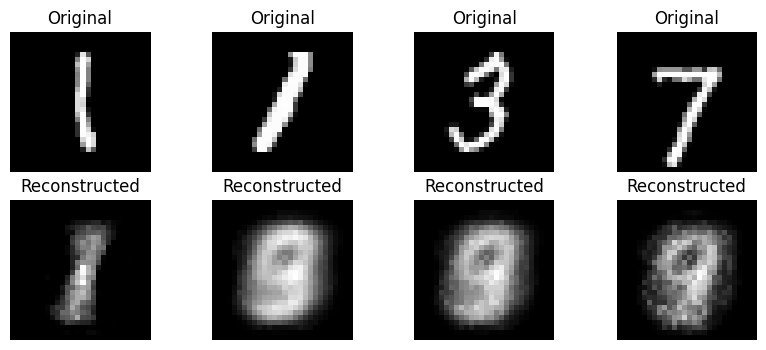

Epoch 90: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.8062


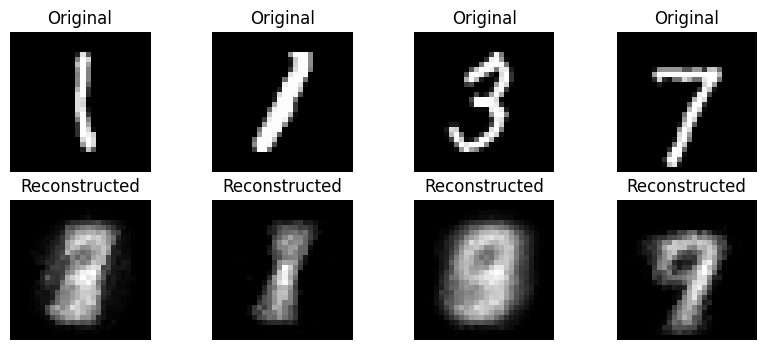

Epoch 91: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.2824


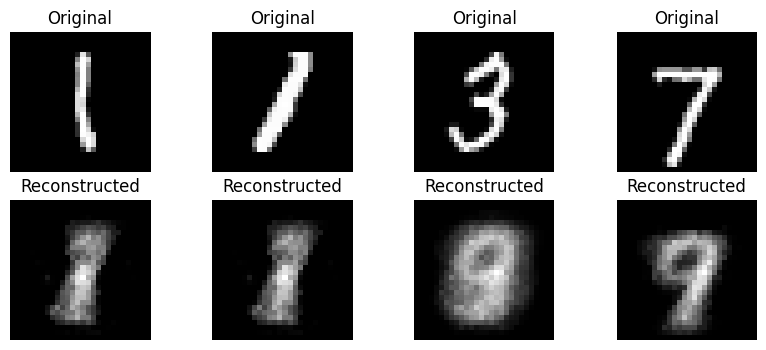

Epoch 92: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.2262


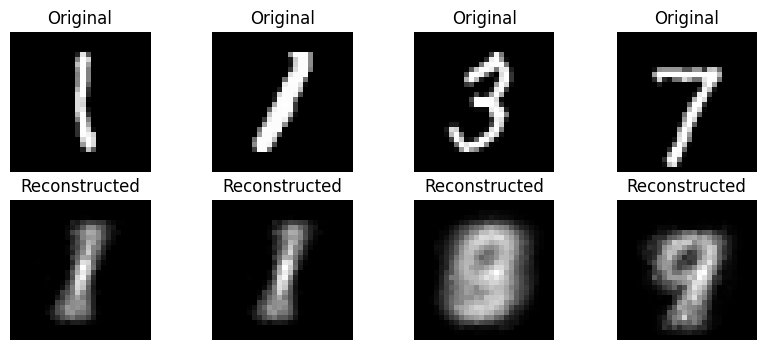

Epoch 93: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.0104


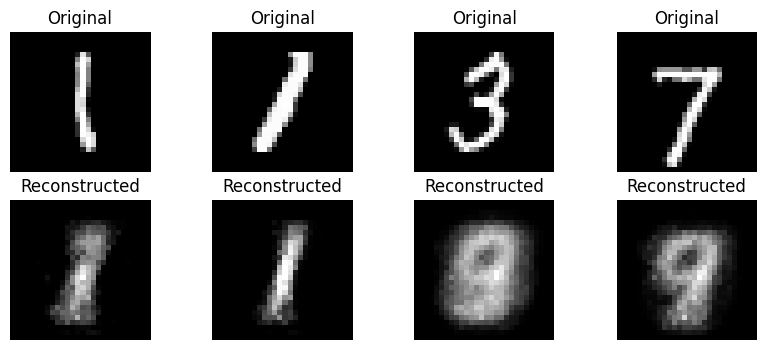

Epoch 94: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.3962


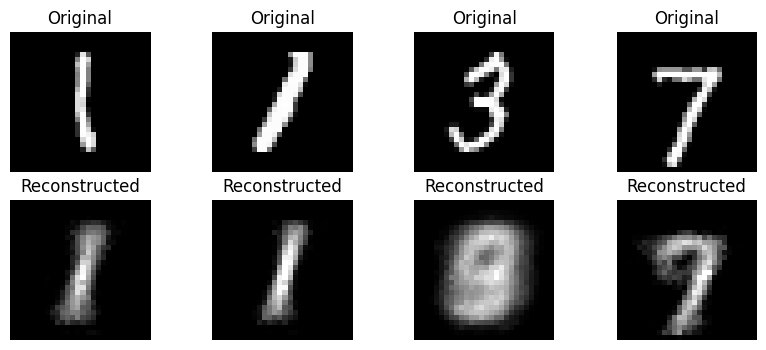

Epoch 95: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 198.9718


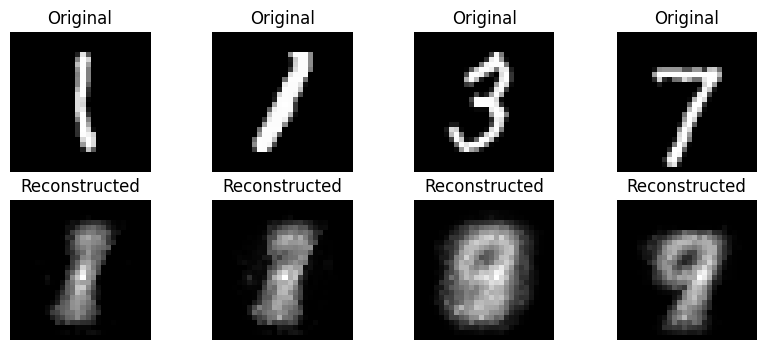

Epoch 96: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.1725


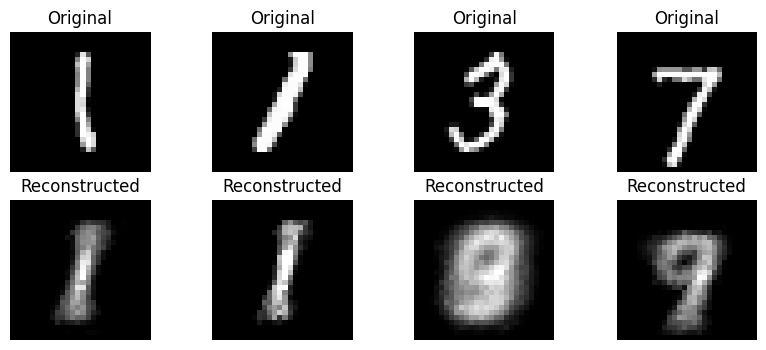

Epoch 97: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 199.7273


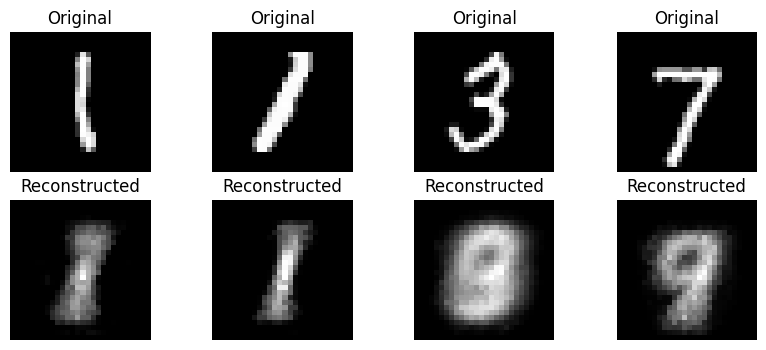

Epoch 98: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 200.2486


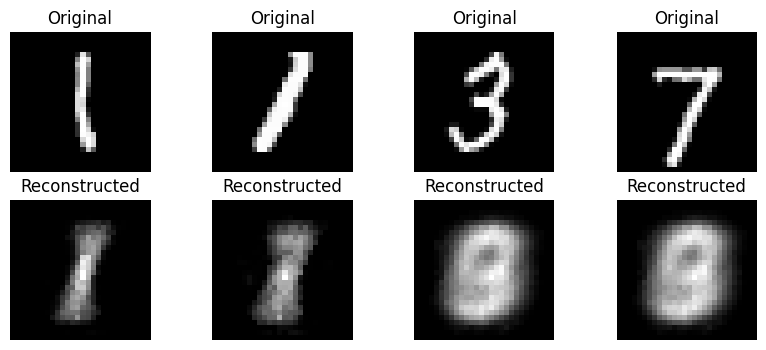

Epoch 99: 


Exception ignored in: <function _releaseLock at 0x79d01acba440>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
input_dim = 784
hidden_dim = 400
latent_dim = 30
model = train_vae(train_loader, latent_dim, hidden_dim, input_dim, num_epochs=20)

0


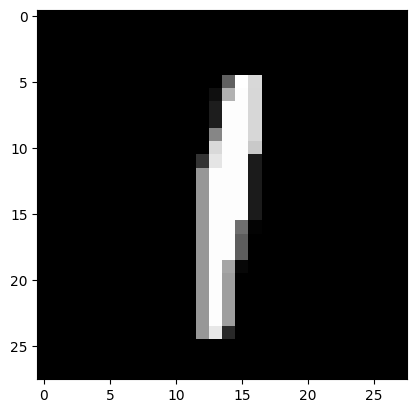

In [ ]:
# Generate reconstructions
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        if batch_idx % 100 == 0:
            print(batch_idx)
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        break

plt.imshow(x[1].view(1, 28, 28).squeeze().cpu().numpy(), cmap='gray')
# plt.imshow(x_hat[1].view(1, 28, 28).squeeze().cpu().numpy(), cmap='gray')
# save_image(x.view(batch_size, 1, 28, 28), "orig_data.png")
# save_image(x_hat.view(batch_size, 1, 28, 28), "reconstructions.png")

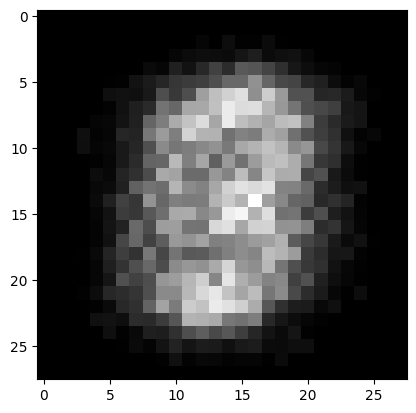

In [ ]:
plt.imshow(x_hat[1].view(1, 28, 28).squeeze().cpu().numpy(), cmap='gray')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape

        self.model = nn.Sequential(
            # TODO
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################

        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.model = nn.Sequential(
            # TODO
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        return x

In [ ]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = # TODO
    discriminator = # TODO
    adversarial_loss = # TODO
    optimizer_G = # TODO
    optimizer_D = # TODO

    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images